In [1]:
import os
import time
from datetime import timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans

from tqdm.notebook import tqdm 

from torch.utils.tensorboard import SummaryWriter

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

from models.transformer_encoder import TransEncoder
from ddpm.ddpm import GaussianDiffusion1D
from evaluation.evaluation import vizual_comparison, plot_jsd_per_customer, plot_kde_samples, make_gif_from_images, mmd_histogram_per_customer

# Params

In [ ]:
## Data
seq_len = 12
batch_size = 256
k = 15

#NN
device = 'cuda' if torch.cuda.is_available() else 'cpu'
latent_dim = 256
cond_model = "mlp"
num_layers = 6
n_heads = 8
lr = 1e-4
betas = (0.9, 0.99)
epochs = 2000
save_rate = 50

## DDPM
timesteps = 1000
beta_schedule = "cosine"
objective = "pred_noise"

## Logging
experiment = "rq1_12"
experiment_name = f"trans_{epochs//1000}kepochs_{seq_len}seq"
logging_dir = f"logging/{experiment}/{experiment_name}/"

In [3]:
if not os.path.isdir(logging_dir):
    os.makedirs(logging_dir)
    os.makedirs(os.path.join(logging_dir, "viz/"))
    os.makedirs(os.path.join(logging_dir, "jsd/"))
    os.makedirs(os.path.join(logging_dir, "kde/"))
    os.makedirs(os.path.join(logging_dir, "tensorboard/"))
    os.makedirs(os.path.join(logging_dir, "weights/"))
    os.makedirs(os.path.join(logging_dir, "mmd/"))
    os.makedirs(os.path.join(logging_dir, "time/"))

# Utils

In [4]:
PREPROCESSED_DIR = "./preprocessing/data/customer_led_network_revolution/preprocessed/"

In [5]:
class MakeDATA(Dataset):
    def __init__(self, data, seq_len):
        data = np.asarray(data, dtype=np.float32)
        seq_data = []
        for i in range(len(data) - seq_len + 1):
            x = data[i : i + seq_len]
            seq_data.append(x)
        self.samples = np.asarray(seq_data, dtype=np.float32) 

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [6]:
def cluster(data, k):
    kmeans = KMeans(n_clusters=k)
    cluster_labels = kmeans.fit_predict(data.T)
    
    clustered_data = []
    for cluster in range(kmeans.n_clusters):
        cluster_data = data.iloc[:, cluster_labels == cluster].mean(axis=1)
        clustered_data.append(cluster_data)
        
    return pd.DataFrame(clustered_data).T

# Load Data

In [7]:
train = pd.read_csv(os.path.join(PREPROCESSED_DIR, "train.csv"))
val = pd.read_csv(os.path.join(PREPROCESSED_DIR, "val.csv"))
test = pd.read_csv(os.path.join(PREPROCESSED_DIR, "test.csv"))
cond_train = pd.read_csv(os.path.join(PREPROCESSED_DIR, "cond_train.csv"))
cond_val = pd.read_csv(os.path.join(PREPROCESSED_DIR, "cond_val.csv"))
cond_test = pd.read_csv(os.path.join(PREPROCESSED_DIR, "cond_test.csv"))

In [8]:
train.drop("Date and Time of capture", axis=1, inplace=True)
val.drop("Date and Time of capture", axis=1, inplace=True)
test.drop("Date and Time of capture", axis=1, inplace=True)

In [9]:
train = cluster(train, k)
test = cluster(test, k)
val = cluster(val, k)

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [10]:
train.shape, val.shape, test.shape, cond_train.shape, cond_val.shape, cond_test.shape

((33984, 15), (6796, 15), (1700, 15), (33984, 27), (6796, 27), (1700, 27))

In [11]:
train_seq = np.asarray(MakeDATA(train, seq_len)).transpose(0, 2, 1)
cond_train_seq = np.asarray(MakeDATA(cond_train, seq_len)).transpose(0, 2, 1)

val_seq = np.asarray(MakeDATA(val, seq_len)).transpose(0, 2, 1)
cond_val_seq = np.asarray(MakeDATA(cond_val, seq_len)).transpose(0, 2, 1)

test_seq = np.asarray(MakeDATA(test, seq_len)).transpose(0, 2, 1)
cond_test_seq = np.asarray(MakeDATA(cond_test, seq_len)).transpose(0, 2, 1)

train_seq.shape, cond_train_seq.shape, test_seq.shape, cond_test_seq.shape

((33973, 15, 12), (33973, 27, 12), (1689, 15, 12), (1689, 27, 12))

In [12]:
train_dataset = TensorDataset(torch.from_numpy(train_seq), torch.from_numpy(cond_train_seq))
train_loader = DataLoader(train_dataset, batch_size, shuffle=False)

val_dataset = TensorDataset(torch.from_numpy(val_seq), torch.from_numpy(cond_val_seq))
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)

test_dataset = TensorDataset(torch.from_numpy(test_seq), torch.from_numpy(cond_test_seq))
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [13]:
real_data_val, real_cond_data_val = next(iter(val_loader))

# Load Model

In [14]:
model = model = TransEncoder(features=train_seq.shape[1], latent_dim=latent_dim, num_heads=n_heads, num_layers=num_layers, cond_features=cond_train_seq.shape[1], cond_model=cond_model, device=device, seq_len=seq_len)

ddpm = GaussianDiffusion1D(model, seq_length=seq_len, timesteps=timesteps, objective=objective, loss_type='l2', beta_schedule=beta_schedule)
ddpm = ddpm.to(device)

optim = torch.optim.Adam(ddpm.parameters(), lr=lr, betas=betas)

writer = SummaryWriter(os.path.join(logging_dir, "tensorboard/"))

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


# Train

In [15]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    
    for i, (data, cond_data) in enumerate(train_loader):
        data = data.to(device)
        
        cond_data = cond_data.float()
        cond_data = cond_data.to(device)
        
        optim.zero_grad()
        
        loss = ddpm(data, cond_data)
        loss.backward()
        
        optim.step()
        running_loss += loss.item()
        
        if i % 100 == 0:
            last_loss = running_loss / 1000 # loss per batch
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
    return last_loss

In [16]:
start_time = time.time()

epoch_number = 0
best_val_loss = 1_000_000.
save_dir =  os.path.join(logging_dir, "weights/")

for epoch in tqdm(range(1, epochs+1)):
    print('epoch {}:'.format(epoch_number + 1))
    
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)
    
    running_val_loss = 0.0
    
    model.eval()
    with torch.no_grad():
        for i, (val_data, val_cond) in enumerate(val_loader):
            val_data = val_data.to(device)
        
            val_cond = val_cond.float()
            val_cond = val_cond.to(device)
            val_loss = ddpm(val_data, val_cond)
            
            running_val_loss += val_loss
    
    avg_val_loss = running_val_loss / (i + 1)
    print('Loss train {} val {}'.format(avg_loss, avg_val_loss))
    
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_val_loss },
                    epoch_number + 1)
    
    writer.flush()
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch_number
        best_ddpm_model = ddpm.state_dict()
        best_optim_state_dict = optim.state_dict()
        
    
    if epoch_number % save_rate == 0:
        generated_sample = ddpm.sample(batch_size, real_cond_data_val.to(device))
        generated_sample = generated_sample.cpu().numpy()
        
        plot_kde_samples(generated_sample, real_data_val,show=False, fpath=os.path.join(logging_dir, "kde/", f"kde_epoch_{epoch_number}.png"), epoch=epoch_number)
        
        model_name = f"model_epoch_{epoch_number}_val_{avg_val_loss:.4f}.pth"
        torch.save({
            'epoch': epoch_number,
            'diffusion_state_dict': ddpm.state_dict(),
            'diffusion_optim_state_dict': optim.state_dict()},
            os.path.join(save_dir, model_name))
    
    epoch_number += 1

end_time = time.time()
elapsed_time = end_time - start_time
formatted_time = str(timedelta(seconds=int(elapsed_time)))

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 1:
Loss train 0.8320974078178406 val 7.035982608795166


sampling loop time step: 100%|██████████| 1000/1000 [00:05<00:00, 187.51it/s]


epoch 2:
Loss train 0.4139537365436554 val 3.9963231086730957
epoch 3:
Loss train 0.22251158022880554 val 2.6830813884735107


sampling loop time step: 100%|██████████| 1000/1000 [00:05<00:00, 193.83it/s]


epoch 4:
Loss train 0.04252752991020679 val 2.5877487659454346
epoch 5:
Loss train 0.0515480345338583 val 1.4875948429107666


sampling loop time step: 100%|██████████| 1000/1000 [00:05<00:00, 192.97it/s]


epoch 6:
Loss train 0.03388664264976978 val 1.520310878753662
epoch 7:
Loss train 0.040261791467666626 val 2.300238847732544


sampling loop time step: 100%|██████████| 1000/1000 [00:05<00:00, 191.05it/s]


epoch 8:
Loss train 0.04018676847219467 val 1.5172563791275024
epoch 9:
Loss train 0.03628030797839165 val 1.3635423183441162


sampling loop time step: 100%|██████████| 1000/1000 [00:05<00:00, 191.91it/s]


epoch 10:
Loss train 0.039082850053906444 val 1.8207465410232544


In [17]:
out_path = os.path.join(logging_dir, "time/", "compute_time.txt")
os.makedirs(os.path.dirname(out_path), exist_ok=True)
with open(out_path, "w") as f:
    f.write(f"Time to train {epochs} epcohs with batch size {batch_size} and sequece {seq_len}: {formatted_time}")

In [18]:
model_name = f"best_model.pth"
torch.save({
    'epoch': best_epoch,
    'diffusion_state_dict': best_ddpm_model,
    'diffusion_optim_state_dict': best_optim_state_dict},
    os.path.join(logging_dir, "weights/", model_name))

In [19]:
ddpm.load_state_dict(torch.load(os.path.join(logging_dir, "weights/", "best_model.pth"))["diffusion_state_dict"])

C:\Users\Arne\AppData\Local\Temp\ipykernel_17012\3440494270.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ddpm.load_state_dict(torch.load(os.path.join(logging_dir, "we

<All keys matched successfully>

In [20]:
paths = []
for kde_plot in os.listdir(os.path.join(logging_dir, "kde/")):
    paths.append(os.path.join(logging_dir, "kde/", kde_plot))

make_gif_from_images(paths, os.path.join(logging_dir, "kde/", "kde_progression.gif"))

# Evaluation

In [21]:
real_data_test, real_cond_data_test = next(iter(test_loader))

In [22]:
with torch.no_grad():
    samples = ddpm.sample(batch_size, real_cond_data_test.to(device))
    samples = samples.cpu().numpy()

print(f"Samples shape: {samples.shape}")

sampling loop time step: 100%|██████████| 1000/1000 [00:05<00:00, 185.11it/s]

Samples shape: (256, 15, 12)


c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


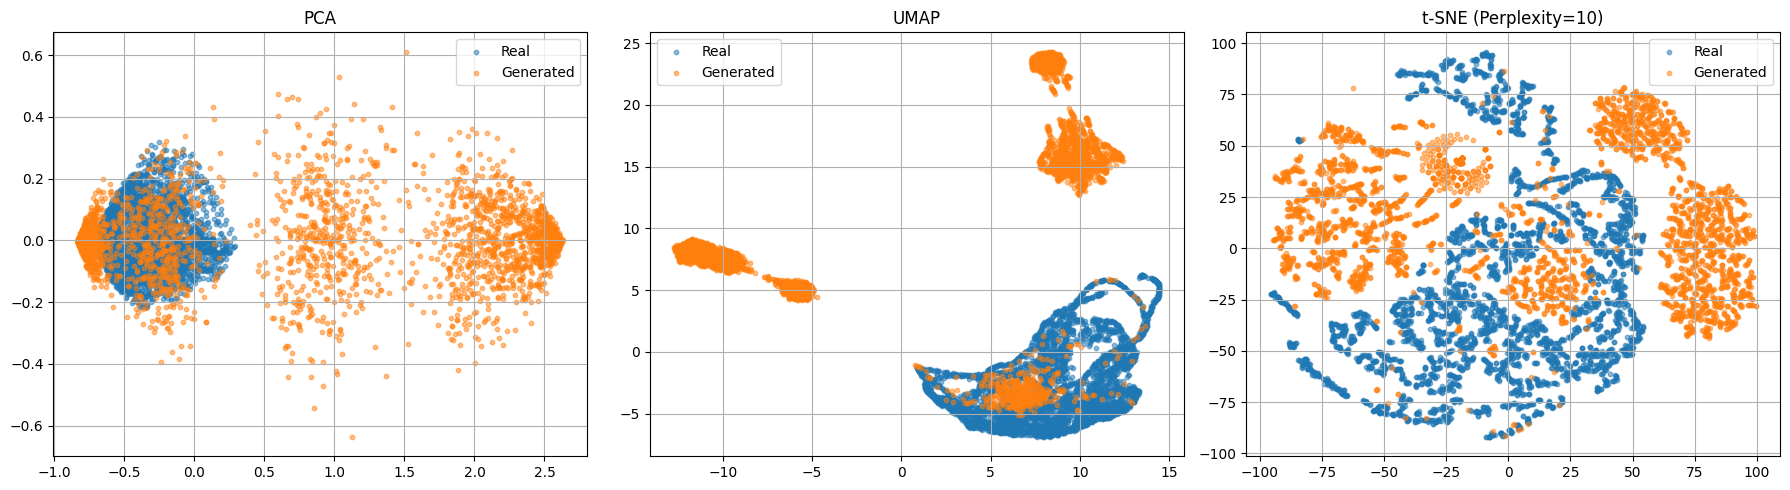

In [23]:
vizual_comparison(samples, real_data_test, os.path.join(logging_dir, "viz/", "pca_umap_tsne_all_batches.png"), use_all_data=True);

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


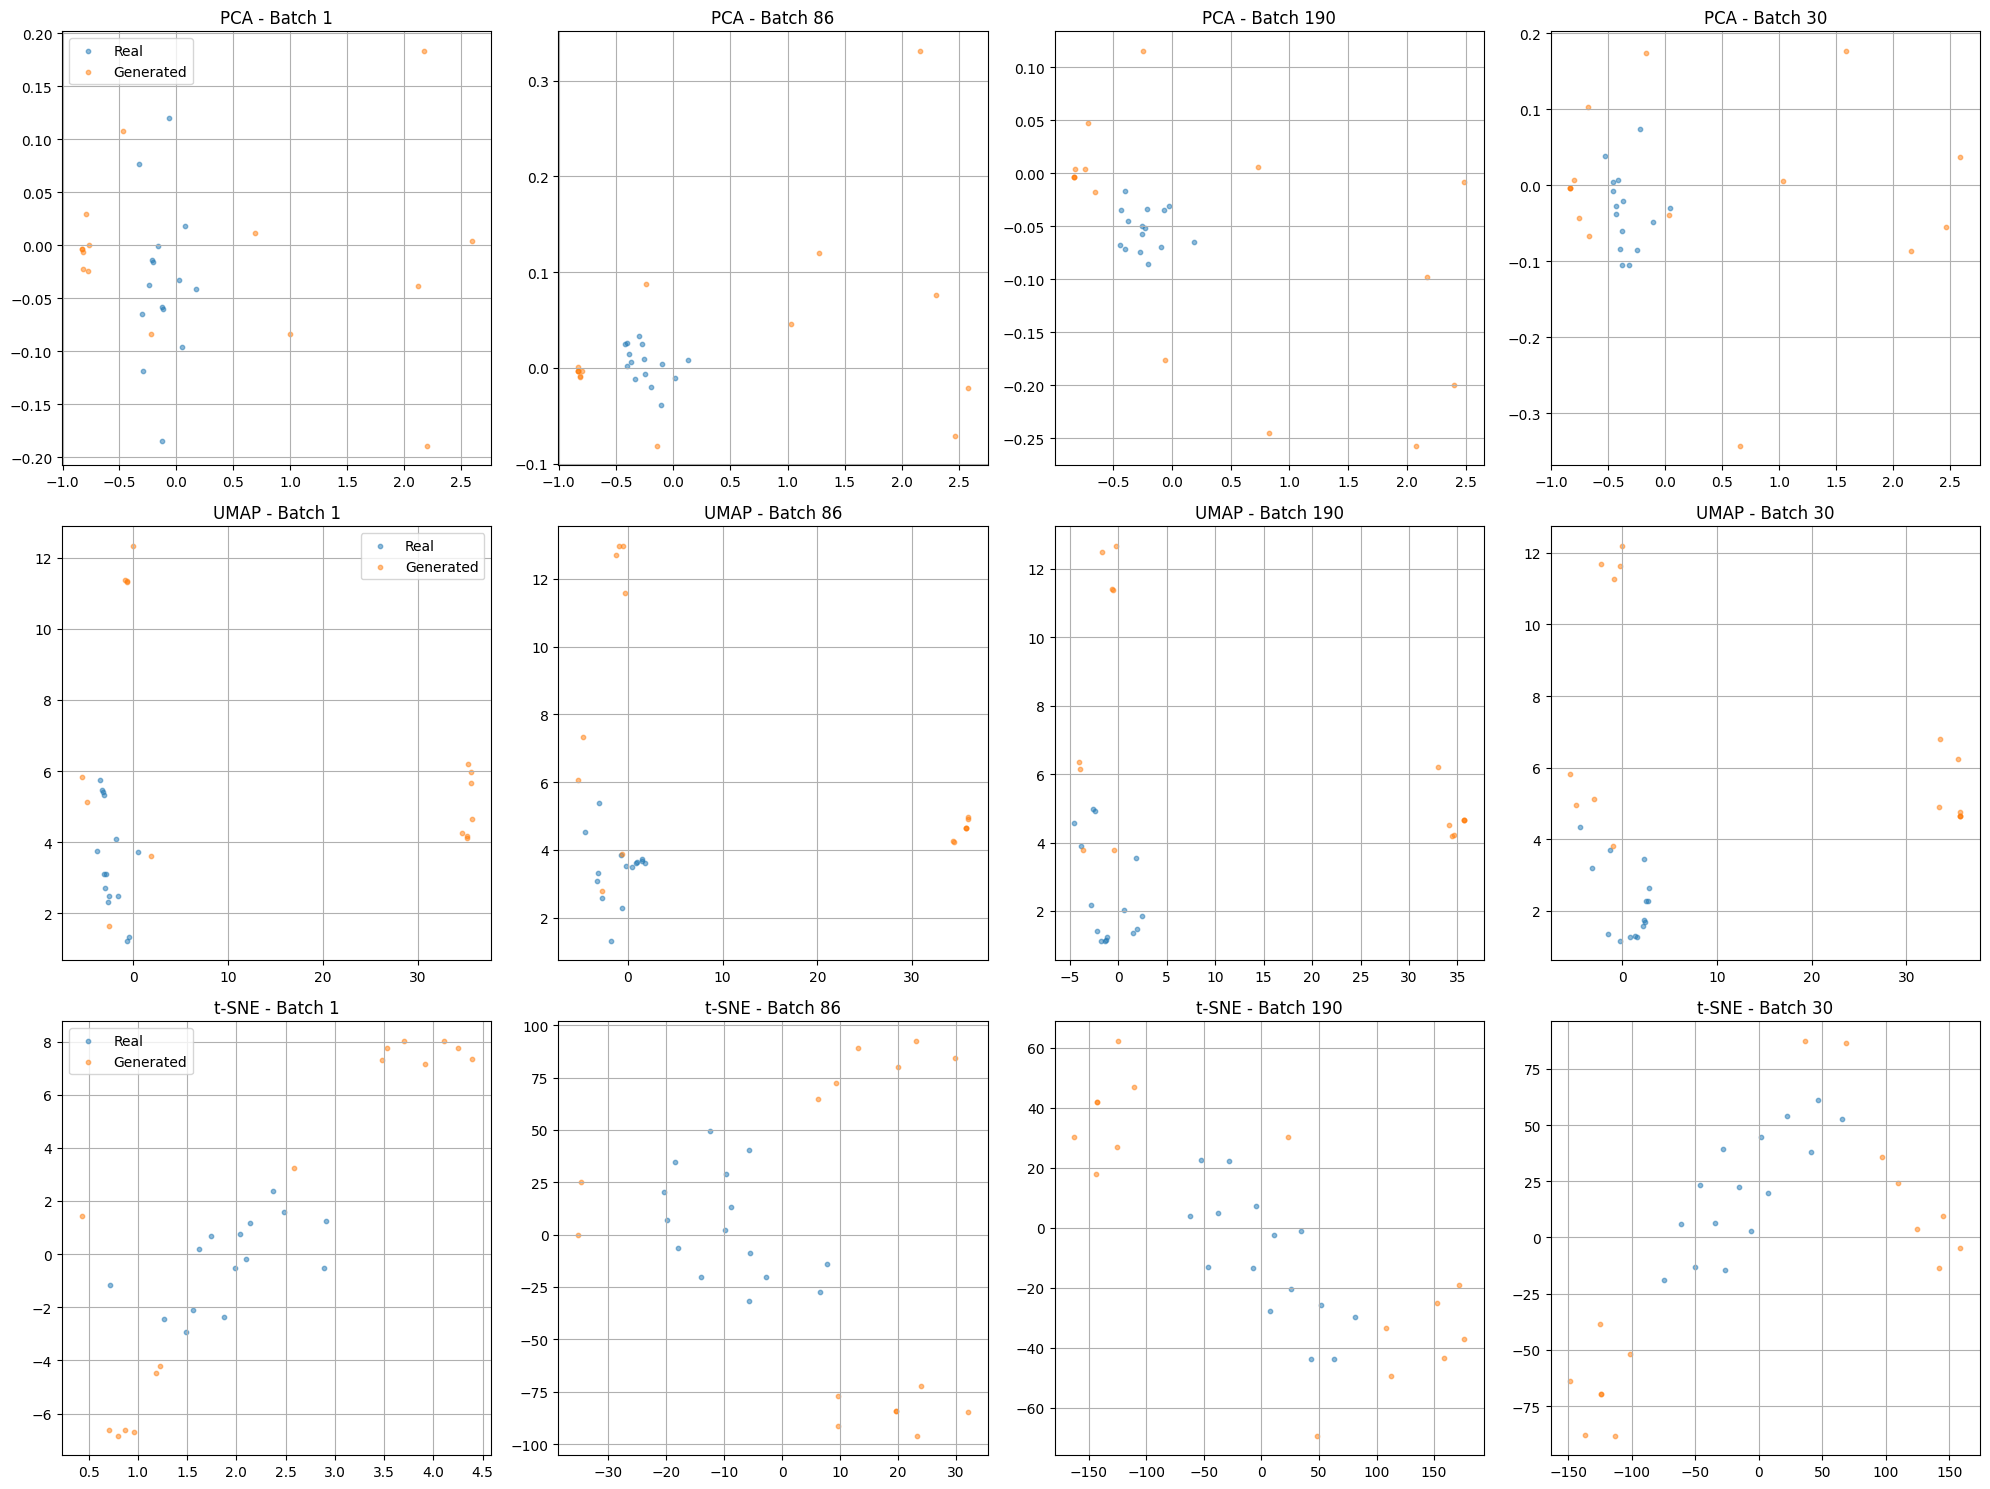

In [24]:
vizual_comparison(samples, real_data_test, os.path.join(logging_dir, "viz/", "pca_umap_tsne_per_batch.png"));

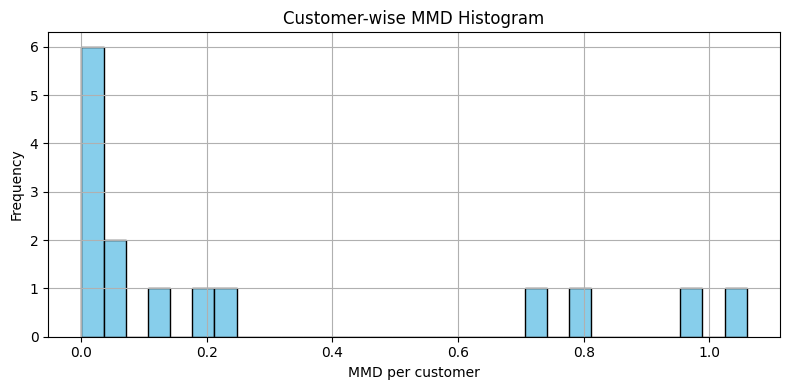

In [25]:
mmd_histogram_per_customer(samples, real_data_test, fpath=os.path.join(logging_dir, "mmd/", "mmd.png"))

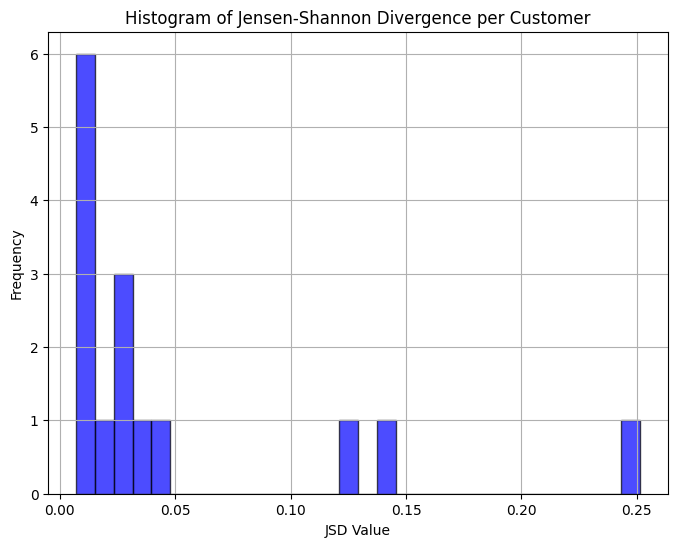

In [26]:
plot_jsd_per_customer(samples, real_data_test, os.path.join(logging_dir, "jsd/", "jsd.png"))

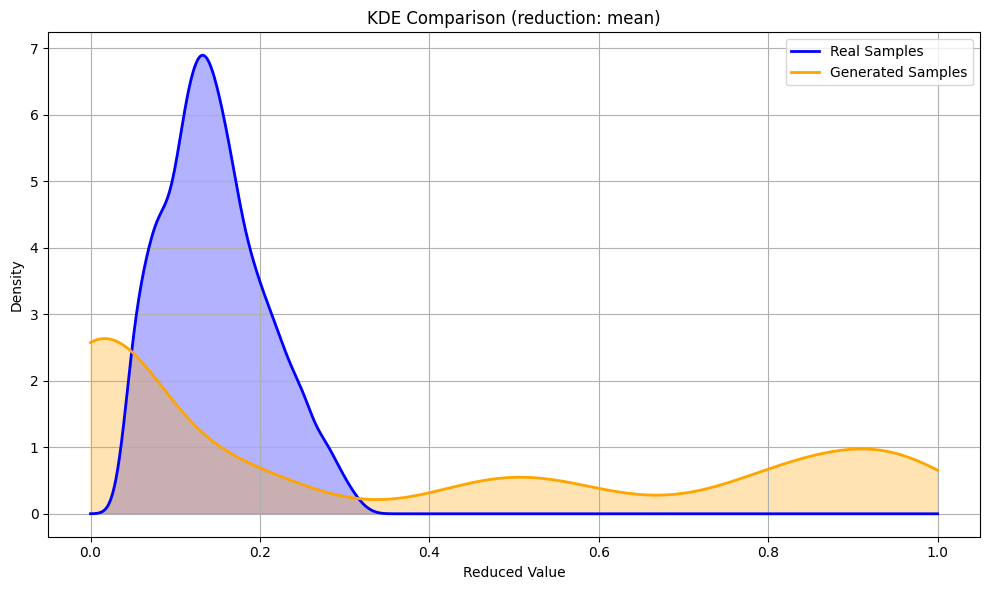

In [27]:
plot_kde_samples(samples, real_data_test, fpath=os.path.join(logging_dir, "kde/", f"kde.png"))

sampling loop time step: 100%|██████████| 1000/1000 [00:05<00:00, 179.63it/s]


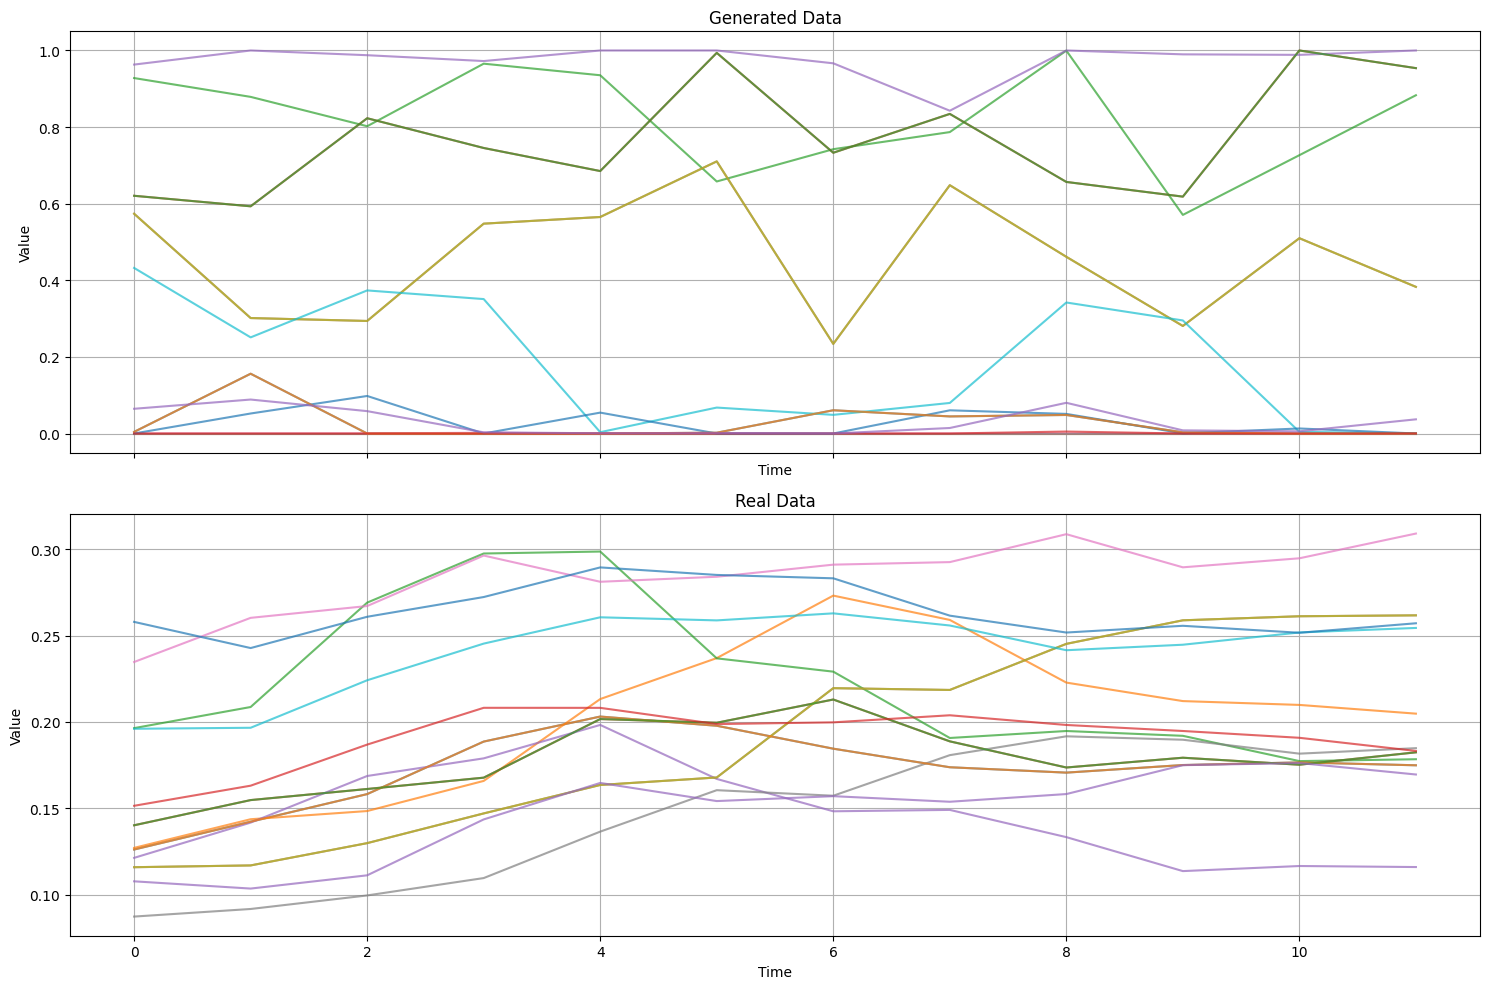

In [28]:
batch_idx = np.random.randint(0, 256) 
customer_indices = np.random.randint(0, 15, size=15)
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

with torch.no_grad():
    sample = ddpm.sample(1, real_cond_data_test.to(device)) 
    sample = sample.cpu().numpy() 

for i in customer_indices:
    axs[0].plot(sample[0, i], alpha=0.7, label=f'Customer {i}')
    axs[1].plot(real_data_test[0, i], alpha=0.7, label=f'Customer {i}')

axs[0].set_title("Generated Data")
axs[1].set_title("Real Data")

for ax in axs:
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(logging_dir, "viz/", "samples.png"))
plt.show()